# Amazon RecSys Data Analysis

이 노트북에서는 `amazon_train.csv` 데이터를 분석하고 전처리를 수행합니다.

## 1. 데이터 로드 및 기초 통계

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로드
df = pd.read_csv('../data/amazon_train.csv')

# 데이터 확인
print("데이터 크기:", df.shape)
print(df.head())

# 유니크 유저 및 아이템 수
n_users = df['user'].nunique()
n_items = df['item'].nunique()
n_interactions = len(df)

print(f"Total Users: {n_users}")
print(f"Total Items: {n_items}")
print(f"Total Interactions: {n_interactions}")
print(f"Sparsity: {1 - n_interactions / (n_users * n_items):.6f}")

데이터 크기: (568263, 3)
             user        item  rating
0  A395BORC6FGVXV  B000UA0QIQ       2
1  A1UQRSCLF8GW1T  B006K2ZZ7K       5
2   ADT0SRK1MGOEU  B006K2ZZ7K       4
3  A1SP2KVKFXXRU1  B006K2ZZ7K       5
4  A3JRGQVEQN31IQ  B006K2ZZ7K       5
Total Users: 256009
Total Items: 74233
Total Interactions: 568263
Sparsity: 0.999970


## 2. 분포 시각화

유저별 구매 횟수와 아이템별 구매 횟수의 분포를 확인합니다.

User Interaction Stats:
count    256009.000000
mean          2.219699
std           4.440991
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         447.000000
dtype: float64

Item Interaction Stats:
count    74233.000000
mean         7.655126
std         26.452906
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        913.000000
dtype: float64


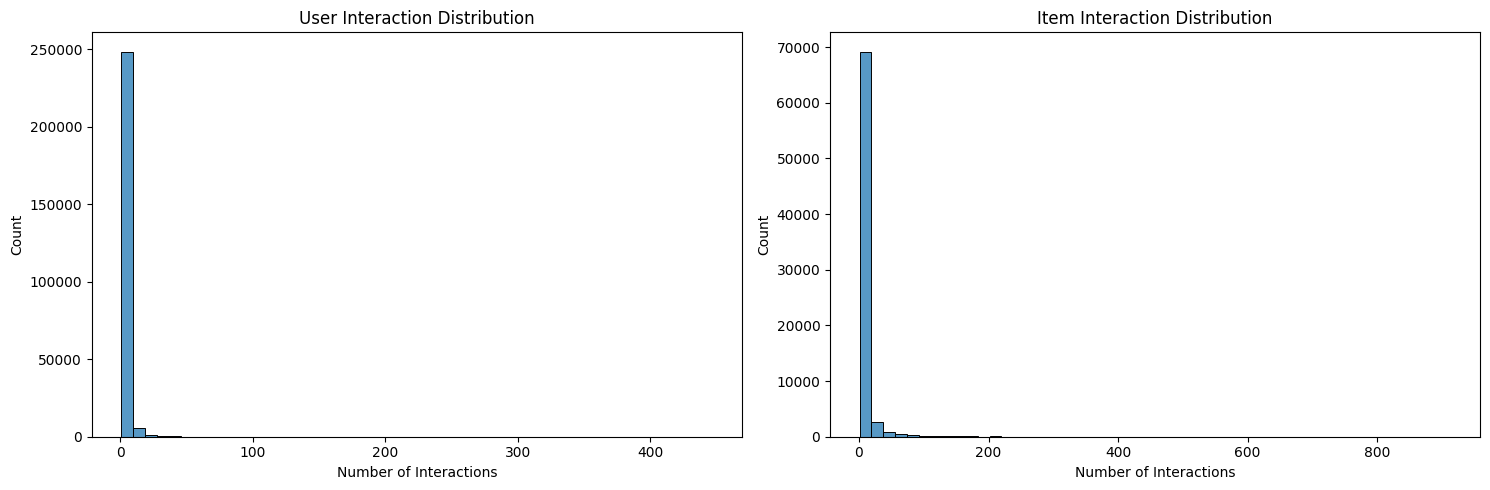

In [2]:
# 유저별 Interaction 수 계산
user_counts = df.groupby('user').size()
item_counts = df.groupby('item').size()

# 기초 통계량
print("User Interaction Stats:")
print(user_counts.describe())
print("\nItem Interaction Stats:")
print(item_counts.describe())

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(user_counts, bins=50, ax=axes[0])
axes[0].set_title('User Interaction Distribution')
axes[0].set_xlabel('Number of Interactions')
axes[0].set_ylabel('Count')

sns.histplot(item_counts, bins=50, ax=axes[1])
axes[1].set_title('Item Interaction Distribution')
axes[1].set_xlabel('Number of Interactions')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

## 3. 새로운 평가 규칙 관련 분석

Interaction이 10개 이하인 유저의 비율을 확인합니다.

In [3]:
low_interaction_users = user_counts[user_counts <= 10]
ratio = len(low_interaction_users) / n_users * 100

print(f"Interactions <= 10인 유저 수: {len(low_interaction_users)}")
print(f"전체 유저 중 비율: {ratio:.2f}%")

Interactions <= 10인 유저 수: 249655
전체 유저 중 비율: 97.52%


## 4. 데이터 전처리 및 저장

User와 Item ID를 0부터 시작하는 인덱스로 매핑하고, Train/Test Split을 수행합니다.
**Split 전략**: 모든 유저가 Train Set에 최소 1개의 Interaction을 가지도록 보장합니다.

In [4]:
from sklearn.model_selection import train_test_split

# User/Item ID Mapping
user_mapper = {u: i for i, u in enumerate(df['user'].unique())}
item_mapper = {i: j for j, i in enumerate(df['item'].unique())}

df['user_idx'] = df['user'].map(user_mapper)
df['item_idx'] = df['item'].map(item_mapper)

# Train/Test Split Strategy
# 1. Interaction이 1개인 유저는 무조건 Train에 포함 (Cold Start 방지)
# 2. Interaction이 2개 이상인 유저는 8:2 비율로 분할하되, Train에 최소 1개는 보장

train_list = []
test_list = []

# 유저별로 그룹화
grouped = df.groupby('user_idx')

for user_idx, group in grouped:
    if len(group) < 2:
        train_list.append(group)
    else:
        # 8:2 분할, 하지만 Train에 최소 1개 보장
        tr, te = train_test_split(group, test_size=0.2, random_state=42)
        train_list.append(tr)
        test_list.append(te)

train_df = pd.concat(train_list)
test_df = pd.concat(test_list)

print(f"Train Size: {len(train_df)}")
print(f"Test Size: {len(test_df)}")

# 데이터 무결성 확인 (모든 유저가 Train에 있는지)
train_users = train_df['user_idx'].unique()
all_users = df['user_idx'].unique()
missing_users = set(all_users) - set(train_users)
print(f"Train Set에 없는 유저 수: {len(missing_users)}")

# 매핑 정보 및 데이터 저장
import pickle

with open('../g3/user_mapper.pkl', 'wb') as f:
    pickle.dump(user_mapper, f)

with open('../g3/item_mapper.pkl', 'wb') as f:
    pickle.dump(item_mapper, f)

train_df.to_csv('../g3/train_data.csv', index=False)
test_df.to_csv('../g3/test_data.csv', index=False)

print("전처리 완료 및 저장됨")

Train Size: 453463
Test Size: 114800
Train Set에 없는 유저 수: 0


전처리 완료 및 저장됨
